# Conv1D for Time Series Classification

### Import libraries

In [22]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import shutil
import sys

import keras_tuner
from tensorflow import keras

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

import warnings
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

2.6.4


In [23]:
# Random seed for reproducibility
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Some Function Definition

Mostly used for Dataset management

In [24]:
def Unroll2D(X,Y):
    
    initialShape = X.shape

    # Flatten the 3D array X into a 2D array
    X_flat = X.reshape(initialShape[0]*initialShape[1],initialShape[2])

    # Get the unique values and counts of the 1D array Y
    classes, classes_count = np.unique(Y, return_counts=True)

    # Calculate the number of elements in each class
    elPerClass = classes_count*initialShape[1]

    # Initialize an empty 1D array for the output Y
    Y_flat = np.empty(0)

    i=0 
    #Build a new Y to match the unrolled dataset
    # Iterate over the number of elements in each class
    for el in elPerClass:
        # Append the label for each element in the current class
        for y in range(el):
            Y_flat=np.append(Y_flat,i)
        # Increment the label for the next class
        i=i+1

    # Verify that all is correct by comparing the counts of the unique values
    # in the output Y with the expected number of elements in each class
    classes, classes_count_post = np.unique(Y_flat, return_counts=True)
    assert classes_count_post.all()==elPerClass.all() 

    # Return the flattened X and Y arrays
    return X_flat, Y_flat

In [25]:
def limitadataset(X,Y,limit=500):
    # Store the shape of the input array X
    shape=X.shape
    
    classes, classes_count = np.unique(Y, return_counts=True)
    for c in classes:
        #get the index of fist-last element of class c
        useless, classes_count = np.unique(Y, return_counts=True)
        FirstIndex = np.sum(classes_count[0:int(c)]) 
        LastIndex = np.sum(classes_count[0:int(c+1)])-1

        while classes_count[int(c)]>limit:
            #remove random elements from a class
            index=random.randint(FirstIndex, LastIndex)
            X = np.delete(X, index, axis=0)
            Y = np.delete(Y, index, axis=0)
            LastIndex-=1
            classes_count[int(c)]-=1
            #endWhile
        #endFor
    useless, classes_count = np.unique(Y, return_counts=True)
    print("Elements x Class: ",classes_count)
    return X,Y

In [26]:
def SelectWindows(X,Y,ws=36,st=0):
    
    X,Y=Unroll2D(X,Y)
    
    finalX = np.empty((0,ws,6))
    finalY = np.empty(0)
    
    classes, classes_count = np.unique(Y, return_counts=True)
    
    count_elementi=0
    for i in classes:
        #get the index of fist-last element of class i
        FirstIndex = np.sum(classes_count[0:int(i)]) 
        LastIndex = np.sum(classes_count[0:int(i+1)])-1 
         
        #get the elements for each windows
        inizio = FirstIndex  
        fine  = inizio + ws-1
        while inizio <= LastIndex:    
            if(fine>LastIndex):
                #add padding if elememnts of a class are not enought 
                element = X[inizio:LastIndex+1,:] 
                padding = np.zeros((fine-LastIndex,6))
                element = np.append(element,padding).reshape(1,ws,6)
            else:
                element = X[inizio:fine+1,:] 
                element = element.reshape(1,ws,6)

            inizio=inizio+ws-st
            fine = fine+ws-st  
            count_elementi=count_elementi+1


            finalX = np.append(finalX,element).reshape(count_elementi,ws,6)
            finalY = np.append(finalY,i).reshape(count_elementi)
            #fine while
        #finefor
    classes, classes_count_post = np.unique(finalY, return_counts=True)
    print("Elementi per Classe: ",classes_count_post)
    return finalX, finalY  
    #fine Fun

### Exploration Data Analysis (EDA)

In [27]:
# Define a function to inspect NumPy arrays
def describe_array(np_array,name):
    print("DESCRIBE "+name.upper())
    print("Dimensions:",np_array.ndim)
    print("Shape:",np_array.shape,"\n")

In [28]:
X_Dataset = np.load("/kaggle/input/an2dl-challenge2/x_train.npy")
Y_Dataset = np.load("/kaggle/input/an2dl-challenge2/y_train.npy")

describe_array(X_Dataset,"X_train")
describe_array(Y_Dataset,"Y_train")

DESCRIBE X_TRAIN
Dimensions: 3
Shape: (2429, 36, 6) 

DESCRIBE Y_TRAIN
Dimensions: 1
Shape: (2429,) 



In [29]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Dataset, Y_Dataset, test_size=0.2, stratify = Y_Dataset)

In [30]:
describe_array(X_train,"trainX")
describe_array(Y_train,"trainY")
print()
describe_array(X_val,"valX")
describe_array(Y_val,"valY")

DESCRIBE TRAINX
Dimensions: 3
Shape: (1943, 36, 6) 

DESCRIBE TRAINY
Dimensions: 1
Shape: (1943,) 


DESCRIBE VALX
Dimensions: 3
Shape: (486, 36, 6) 

DESCRIBE VALY
Dimensions: 1
Shape: (486,) 



In [31]:
label_mapping = {
    0: "Wish",
    1: "Another",
    2: "Comfortably",
    3: "Money",
    4: "Breathe",
    5: "Time",
    6: "Brain",
    7: "Echoes",
    8: "Wearing",
    9: "Sorrow",
    10: "Hey",
    11: "Shine"
}

In [32]:
# Apply RobustScaler to the useful features
Xt,Yt=Unroll2D(X_train,Y_train)
Xv,Yv=Unroll2D(X_val,Y_val)

scaler = RobustScaler()
scaler = scaler.fit(Xt)

X_train = scaler.transform(Xt).reshape(X_train.shape)
X_val = scaler.transform(Xv).reshape(X_val.shape)

In [33]:
# To save the scaler parameters
if not os.path.exists('/kaggle/working/export.obj'):
    import pickle 
    import math 
    
    filehandler = open('export.obj', 'wb') 
    pickle.dump(scaler, filehandler)
    filehandler.close()

In [34]:
# Convert the sparse labels to categorical values
Y_train = tfk.utils.to_categorical(Y_train)
Y_val = tfk.utils.to_categorical(Y_val)

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((1943, 36, 6), (1943, 12), (486, 36, 6), (486, 12))

# Build and train models

In [35]:
input_shape = X_train.shape[1:]
classes = Y_train.shape[-1]
batch_size = 64
epochs = 1000

## Conv1D

In [36]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    dropRate = 0.35
    
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    #cnn = normalizationLayer(input_layer)
    
    # Feature extractor
    cnn = tfkl.Conv1D(256,6,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    
    cnn = tfkl.Conv1D(512,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    
    dropout = tfkl.Dropout(0.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation=tfkl.LeakyReLU())(dropout)
    classifier = tfkl.Dropout(dropRate, seed=seed)(classifier)
    
    classifier = tfkl.Dense(128, activation=tfkl.LeakyReLU())(classifier)
    classifier = tfkl.Dropout(dropRate, seed=seed)(classifier)
    
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [37]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 36, 6)]           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 36, 256)           9472      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 18, 256)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 18, 512)           393728    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 512)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664 

## Train The model 

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    verbose=2,
    validation_data = (X_val, Y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=60, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=20, min_lr=0.0001)
    ]
).history

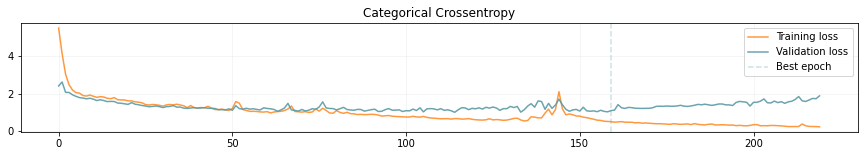

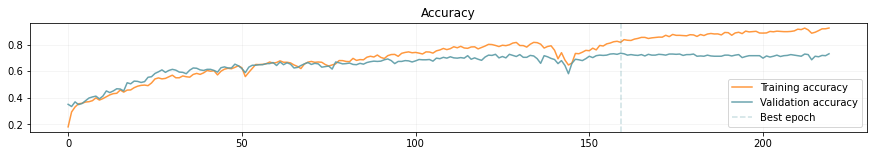

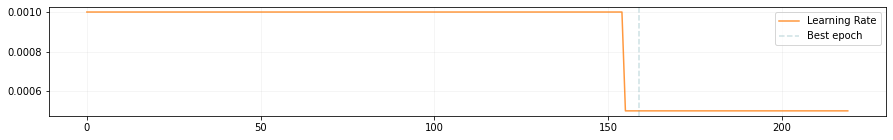

In [39]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(15,2))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=0.15)
plt.show()

plt.figure(figsize=(15,2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.15)
plt.show()

plt.figure(figsize=(15,2))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=0.15)
plt.show()

Accuracy: 0.7366
Precision: 0.751
Recall: 0.5956
F1: 0.6353
              precision    recall  f1-score   support

           0      1.000     0.429     0.600         7
           1      0.750     0.720     0.735        25
           2      0.927     0.944     0.936        54
           3      0.618     0.553     0.583        76
           4      0.000     0.000     0.000        12
           5      0.550     0.355     0.431        31
           6      0.775     0.873     0.821        63
           7      1.000     0.214     0.353        14
           8      0.955     0.875     0.913        24
           9      0.682     0.884     0.770       155
          10      0.923     0.800     0.857        15
          11      0.833     0.500     0.625        10

    accuracy                          0.737       486
   macro avg      0.751     0.596     0.635       486
weighted avg      0.727     0.737     0.716       486


[[  3   0   0   0   0   0   0   0   0   0   0   0]
 [  0  18   0   2   0

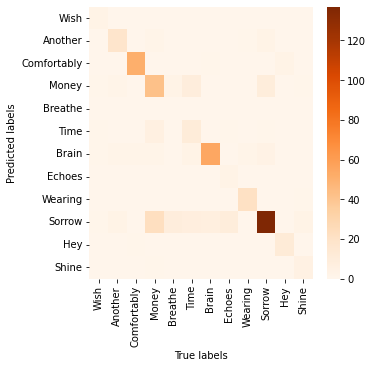

In [40]:
#prediction and evaluation is done on the Validation dataset
predictions = model.predict(X_val)
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

print(classification_report(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1), digits=3))
print()
print(cm.T)

# Plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm.T, cmap='Oranges', xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [41]:
def multiple_build_models(repetitions=3):
    models= []
    histories = []
    metrics = []
    confusion = []
    
    for i in range(repetitions): 
        print("sto trainando il modello numero: ",i)
        model = build_1DCNN_classifier(input_shape, classes)
        
        # Train the model
        history = model.fit(
            x = X_train,
            y = Y_train,
            batch_size = batch_size,
            epochs = epochs,
            verbose=0,
            validation_data = (X_val, Y_val),
            callbacks = [
                tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=60, restore_best_weights=True),
                keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=20, min_lr=0.0001)
            ]
        ).history

        predictions = model.predict(X_val)
        # Compute the confusion matrix
        cm = confusion_matrix(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1))

        # Compute the classification metrics
        accuracy = accuracy_score(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1))
        precision = precision_score(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
        recall = recall_score(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
        f1 = f1_score(np.argmax(Y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
        
        print('\tAccuracy:',accuracy.round(4))
        print('\tPrecision:',precision.round(4))
        print('\tRecall:',recall.round(4))
        print('\tF1:',f1.round(4),"\n")
        
        print(cm.T)
        print("\n\n")
        
        models.append(model)
        histories.append(history)
        metrics.append((accuracy.round(4),precision.round(4),recall.round(4),f1.round(4))) 
        confusion.append(cm) 
        
    return models,histories,metrics,confusion

In [42]:
#train multiple time the same model to try overcome variability in models
models, histories, metrics, confusion_matrix = multiple_build_models()

sto trainando il modello numero:  0
	Accuracy: 0.7449
	Precision: 0.7461
	Recall: 0.6355
	F1: 0.6619 

[[  3   0   0   0   0   0   0   0   0   0   0   0]
 [  0  16   0   1   0   0   0   0   1   2   0   0]
 [  0   0  52   0   0   0   1   0   0   0   1   0]
 [  2   4   0  47   5  10   0   2   0  19   0   1]
 [  0   0   0   1   1   0   0   0   0   0   0   0]
 [  1   0   0   7   0  14   1   0   0   0   0   0]
 [  0   1   1   1   0   2  52   0   0   2   0   0]
 [  0   0   0   0   0   0   1   4   0   2   0   0]
 [  0   1   0   0   0   0   3   0  23   0   0   1]
 [  0   3   0  16   6   5   5   8   0 130   0   2]
 [  1   0   1   0   0   0   0   0   0   0  14   0]
 [  0   0   0   3   0   0   0   0   0   0   0   6]]



sto trainando il modello numero:  1
	Accuracy: 0.7407
	Precision: 0.776
	Recall: 0.5994
	F1: 0.6455 

[[  3   0   0   0   0   0   0   0   0   0   0   0]
 [  0  17   0   4   0   0   0   0   1   2   0   0]
 [  0   0  52   1   0   0   1   0   1   0   3   0]
 [  1   3   0  43   4   7 

In [43]:
#save the model
name_model = 'conv1D'
models[0].save(name_model)
shutil.make_archive(name_model, 'zip', "./"+name_model)


'/kaggle/working/conv1D.zip'